<a href="https://colab.research.google.com/github/stmarple/MachineLearningWithTensorFlow/blob/master/FFNN_MNST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST (aka Modified National Institute of Standards and Technology Database) 
is a large database of handwritten digits used for training various image processing systems.
https://en.wikipedia.org/wiki/MNIST_database

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

### **Load and Prepare the MNIST Dataset**

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


### **Build the `tf.keras.Sequential` model by stacking layers**

In [0]:
modelA = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

modelA.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### **Train and evaluate the model**
Before we begin, we should go over a few important **hyperparameters**:

1. epoch, which is the total training sequences
2. batch_size, which is the training batch size
3. display_freq, which is the frequency of results displaying
4. learning_rate, which is the initial optimization learning rate

see https://www.easy-tensorflow.com/tf-tutorials/neural-networks/two-layer-neural-network?view=article&id=124:two-layer-neural-network for more information.

In [33]:
historyA = modelA.fit(x_train, y_train, epochs=5)
loss, accuracy  = modelA.evaluate(x_test,  y_test, verbose=2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0428 - acc: 0.9855
Epoch 2/5
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0316 - acc: 0.9894
Epoch 3/5
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0284 - acc: 0.9905
Epoch 4/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0263 - acc: 0.9912
Epoch 5/5
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0235 - acc: 0.9916
10000/10000 - 0s - loss: 0.0678 - acc: 0.9815


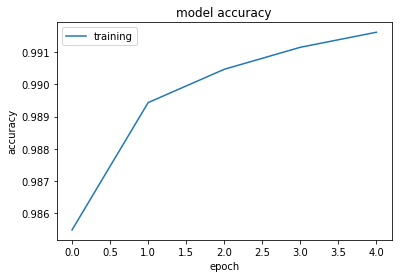

Test loss: 0.0678
Test accuracy: 0.982


In [37]:
import matplotlib.pyplot as plt

plt.plot(historyA.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')


Enter an index over 4440: 1500
7


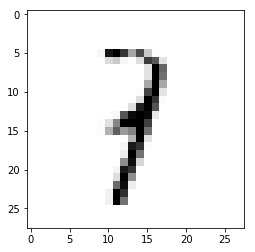

In [38]:
img = int(input('Enter an index over 4440: '))
plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
pred = modelA.predict(x_test[img].reshape(1, 28, 28))
print(pred.argmax())



---



# Classification of MNIST Digits
https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3

**Shape**

In [5]:
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (60000, 28, 28)
Test data shape:  (10000, 28, 28)


**Flatten Images**

In [0]:
img_vector_size = 28**2
x_train = x_train.reshape(x_train.shape[0], img_vector_size)
x_test = x_test.reshape(x_test.shape[0], img_vector_size)

### Create a Vector

In [7]:
import keras
from keras.datasets import mnist

# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training label shape: '   , y_train.shape) # 60000 numbers (all 0-9)
print('First 5 training labels: ', y_train[:5]) # [5, 0, 4, 1, 9]

# Convert to vectors using the to_categorical function
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('First 5 training lables as one-hot encoded vectors:\n', y_train[:5])


Using TensorFlow backend.


Training label shape:  (60000,)
First 5 training labels:  [5 0 4 1 9]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### For fully connected neural networks, there are three essential questions that define the network’s architecture:
1. How many layers are there?
2. How many nodes are there in each of those layers?
3. What transfer/activation function is used at each of those layers?

### There are 2 factors that contribute to the performance of a neural network: 
* The loss function  
* The optimization algorithm used

Per the article mentioned above, the author selects:
* A *common loss function*: **the categorical cross entropy** and 
* One of the simpler *optimization alogorithms*: **the stocastic gradient descent (SGD)**

**What is cross entropy loss?**  It is a log loss that measures the performance of a classification model whose output is based on a probability between 0 and 1.

More information on loss functions and optimiizers can be found here: https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#sgd

## Creating First Model
Dense layers are "fully connected" layers
Documentation: https://keras.io/models/sequential/

The input layer requires the special input_shape parameter which should match the shape of our training data.

The **image_size** is a created by flattening an image to **28 X 28 or 28^2 = 784**

**num_classes** represents the number of output nodes or probabilities

This model has **a single hidden layer**, **that has 32 nodes, or 32 biases** using the sigmoid activation function

And, since there are 784 square units, on 1 layer, that has 32 nodes, there are **784 x 1 x 32 = 25,088 weights**, where weights represent the number of pixels

Therefore, there are 25,088 + 32 biases = **25,120 parameters**

There are 32 x 10, or **320 weights from hidden layer to output layer**.

Each of the 10 nodes adds a single bias >> 25,120 par + 320 weights + 10 nodes = **25,450 total parameters**



In [8]:
from keras.layers import Dense, Flatten 
from keras.models import Sequential 

image_size = 784 # 28*28
num_classes = 10 # ten unique digits

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


### This model contains a special activation function: the softmax.
What makes it special is that it normalizes the values from the 10 output nodes in such a way that:
* all the values are between 0 and 1
* the sum of all 10 values = 1

To put it another way, Softmax "calculates the probabilities distribution of the event over 'n' different events".  In this case, there are 10 possible probabilities, with the largest as the prediction vector.  These probabilities "will be helpful when determining the target class for the given inputs".

More information on activation functions can be found here:
https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html


## Train and Evaluate The Model

In [9]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 1s 26us/step - loss: 1.3984 - acc: 0.6519 - val_loss: 0.9606 - val_acc: 0.8258
Epoch 2/5
54000/54000 [==============================] - 1s 23us/step - loss: 0.8597 - acc: 0.8271 - val_loss: 0.6813 - val_acc: 0.8827
Epoch 3/5
54000/54000 [==============================] - 1s 25us/step - loss: 0.6816 - acc: 0.8582 - val_loss: 0.5597 - val_acc: 0.8953
Epoch 4/5
54000/54000 [==============================] - 1s 25us/step - loss: 0.5860 - acc: 0.8712 - val_loss: 0.4867 - val_acc: 0.8993
Epoch 5/5
54000/54000 [==============================] - 1s 24us/step - loss: 0.5245 - acc: 0.8791 - val_loss: 0.4343 - val_acc: 0.9060


### Graph That

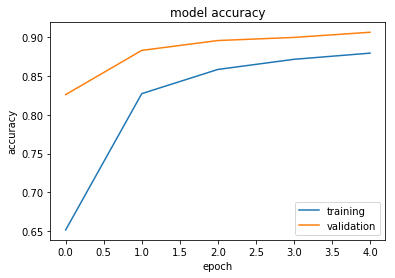

Test loss: 0.482
Test accuracy: 0.89


In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## Create, Test, Evaluate, and Graph Again
This time, rather than having a single layer with only 32 nodes, let's increase that to 128 nodes

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 2s 39us/step - loss: 1.0417 - acc: 0.7328 - val_loss: 0.5801 - val_acc: 0.8775
Epoch 2/5
54000/54000 [==============================] - 2s 34us/step - loss: 0.5532 - acc: 0.8678 - val_loss: 0.4175 - val_acc: 0.9045
Epoch 3/5
54000/54000 [==============================] - 

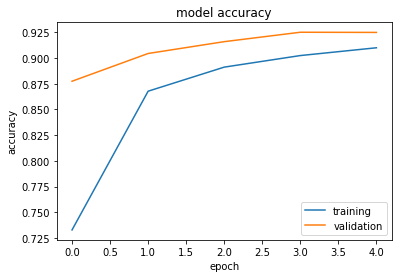

Test loss: 0.322
Test accuracy: 0.916


In [18]:
image_size = 784 # 28*28
num_classes = 10 # ten unique digits

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units=128, activation='sigmoid', input_shape=(image_size,))) # increase from 32 nodes to 128 **
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=5, validation_split=0.1)
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

It looks like the training model has gotten much better.  However, there is still much to be done about the test loss of more than 32%.

### Let's see what this model can predict...

Enter an index over 4440: 1500
1


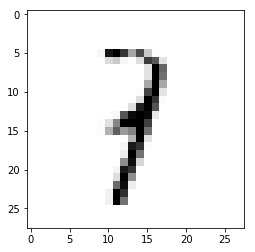

In [26]:
img = int(input('Enter an index over 4440: '))
plt.imshow(x_test[img].reshape(28,28),cmap='Greys')
pred = model.predict(x_test[img].reshape(1, 28, 28))
print(pred.argmax())

## Network Depth and Layer Width
https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3 **continues...**
